## Как учатся машины

Предположим, мы хотим определить цену машины по таким параметрам:

- пробег
- мощность в лошадиных силах,
- тип топлива,
- потребление топлива (литров за 1 км) 
- количество дверей,
 
Кажется, цена может быть линейно связана с каким-то показателем (например, с потреблением топлива)
price = a + b * l/km

Как найти a и b?  Это - параметры прямой (от них будет зависеть ее наклон и положение в пространстве)

Какая линия -- лучшая? Лучшая линия -- та, которая отражает положение данных. С одним параметром это не сложно, но у нас много параметров:
price = a + b * пробег + c * мощность + d * топливо + e * двери

Пространоство признаков стало многомерным,и вместо прямой, положение данных будет отражает другое подпространство. Задача алгоритма во время обучения -- подобрать наилучшее подпространство

## Overfitting, Underfitting

![](overfitting_underfitting.png)

Как избавиться от переобучения (overfitting)

- Cross-validation
- Train with more data
- Early stopping
- Regularization
- Ensembling


Как избавиться от недообучения (underfitting)

- увеличить набор параметров в модели
- выбрать другой алгоритм
- увеличить время обучения и выбрать другую функцию ошибок

## Cost Function

![](cost_function.png)



([подробнее про cost function](https://towardsdatascience.com/machine-learning-fundamentals-via-linear-regression-41a5d11f5220))

## практическая часть

In [1]:
# import os
import numpy as np
import pandas as pd
pd.set_option('max_columns', None) # не "прячет" колонки датафрейма

import matplotlib.pyplot as plt
import seaborn
 
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import linear_model

In [4]:
import warnings
warnings.filterwarnings('default') # ignore = спрятать warnings

In [3]:
from sklearn.datasets import make_classification # генерация рандомного датасета для классификации


### создание своего датасета (random seed, data exploration)

подробнее про [make classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [5]:
X, y = make_classification(n_classes=2,
    weights=[0.7, 0.3], # proportions of samples assigned to each class
                           
    n_informative=40, n_redundant=45, n_features=200, 
    n_clusters_per_class=4, 
    n_samples=1000, random_state=4) #np.random.randint(10000)

In [6]:
display(X.shape)
X[:5, :4] # смотрим на часть матрицы признаков, а вообще она большая

(1000, 200)

array([[ 0.66794613, -0.44650395,  5.64069283, -0.28023025],
       [-2.33136302,  2.49864479,  8.31145909, -0.75826268],
       [ 2.51575636,  0.34813661, -7.31985531, -0.53124425],
       [-0.23757112,  1.26118129, -8.42500608, -0.95282484],
       [ 0.27468395,  1.22836553,  6.83314928,  1.19859023]])

In [7]:
display(y.shape)

y[:5] # часть вектора, каждое значение - это класс отдельного объекта 

(1000,)

array([1, 0, 1, 1, 1])

Теперь у нас есть матрица (X) с признаками и весами этих признаков, а еще есть вектор (y), определяющий каждый семпл в отдельный класс. Давайте посмотрим на признаки

In [8]:
features = pd.DataFrame(X) # сделаем матрицу датафреймом

In [9]:
answers = pd.DataFrame(y) # и вектор тоже

In [15]:
display(features)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.667946,-0.446504,5.640693,-0.280230,1.127176,0.156926,-0.274880,2.061331,-6.356127,-0.711648,-0.370422,-2.076365,-20.454933,0.010770,0.123864,-0.902056,-4.970401,17.719842,-1.194178,-1.954417,0.377822,0.026155,-0.522323,-0.007539,-0.349424,7.725302,-3.322912,1.221860,0.419555,-0.051742,-1.132596,2.328500,0.414228,-1.013687,-6.023231,-1.059694,0.341396,33.636651,-0.895732,10.514448,-0.170948,1.045143,-0.295182,-0.077190,-13.319415,-0.347707,28.499257,-14.077534,9.591966,-0.948609,1.293034,1.820799,-0.741307,-1.305574,-1.866633,-13.795858,-5.724251,0.861457,1.242806,-0.506295,-0.900147,10.116606,0.372569,11.317350,0.470881,0.208525,-0.424624,0.731761,-7.463082,0.327844,-8.929532,3.557668,-1.910527,-8.213045,1.037234,0.266118,0.116978,2.163859,1.357875,-0.815970,-2.262995,0.844165,-0.931316,9.830470,0.167373,4.119030,-0.417450,-0.683867,-0.220153,-14.265751,-13.256041,-0.216323,-0.525506,3.949591,-0.232478,15.720493,0.282084,0.224325,1.675171,-4.149848,-0.252159,-1.659091,0.905723,7.348972,3.625939,1.072769,-0.059601,-0.133609,0.144963,5.932241,-2.459439,1.293114,0.315310,-0.660278,0.183914,-0.777194,-2.944050,-0.084240,-0.345834,-0.590993,-13.546005,1.112738,-28.924876,0.546699,-7.070731,12.939645,12.013359,0.468738,10.320342,-2.410752,-0.096557,0.329471,0.074982,-1.145082,-7.665543,-0.838900,-1.210972,-5.097623,28.254548,-0.115358,-2.185741,-7.711975,13.264119,-0.372511,1.056033,-7.974469,1.486299,-0.964245,-6.572461,0.878311,-6.295420,1.156623,-2.520632,1.245917,0.121300,-1.182466,3.445565,-10.822919,-5.078148,3.390242,1.765942,1.249458,-0.746097,-10.057801,-0.086311,-1.177501,1.370562,-6.781467,2.117031,-0.869492,-10.806273,-5.878951,2.567471,-0.096064,0.312144,0.419940,-0.364009,-1.933155,-0.335087,-15.918795,1.228100,0.638014,-0.292579,1.279443,1.249073,0.534604,0.145896,0.752524,-0.548268,0.529525,-2.017164,-5.092801,0.393569,-20.370275,2.099514,-1.877060,-27.013760,0.374412,1.801518,0.714045
1,-2.331363,2.498645,8.311459,-0.758263,-0.328875,0.099240,0.266081,0.061667,7.031661,-2.525589,-0.578008,-10.190880,-4.015664,0.610291,1.055305,0.715721,2.624461,-0.107469,-1.749661,-1.389411,-2.253262,0.533338,-0.250870,0.562775,-0.182075,-0.090784,0.856041,-0.187266,-1.246936,-0.298979,-4.387155,-1.717258,4.790719,-0.194156,5.583631,-0.921124,0.432795,4.572043,-0.130313,-1.168642,-0.456650,0.311330,-1.972073,-2.192145,-6.835264,0.453161,2.599034,15.457910,2.013786,-0.064155,-0.909745,-0.523177,0.833515,-1.069019,-0.173547,16.207733,16.756091,-1.149082,1.216245,0.265909,0.010415,-1.234870,1.709549,-0.045836,-0.577314,0.357488,5.492527,1.121929,6.396339,-0.302605,-1.654486,1.308704,2.591335,-3.111319,0.436551,0.690304,1.487927,-4.019947,-2.457339,0.258247,0.017689,-0.781373,-0.406938,-4.636492,-0.630877,-1.155878,1.668252,-0.026640,0.851248,15.484987,-4.165446,-5.708893,1.055557,0.997186,2.219414,3.565079,-0.960294,1.126387,-0.583324,-4.384832,0.071677,-0.128336,-0.225189,0.775856,-3.430570,2.200174,-0.621778,0.268652,-5.229081,0.723843,-0.443668,-2.248822,-0.697671,0.800050,-1.647223,0.942408,-2.858054,0.843649,-0.836984,0.319856,12.063793,-0.662641,15.144911,1.175362,-11.268109,-5.815923,-4.093591,-0.224645,14.443810,-10.391992,2.895952,-0.566683,0.644903,0.166050,2.687083,-0.515515,-0.843524,12.062081,7.882512,-0.114125,-1.812243,15.592132,-0.981972

In [16]:
display(answers)

,0
0,1
1,0
2,1
3,1
4,1
...,...
995,1
996,0
997,0
998,0


0       3.781326
1       1.004500
2      15.155788
3       0.997048
4       1.010556
         ...    
195     1.001447
196    13.477308
197     1.044123
198     1.014653
199     0.967483
Length: 200, dtype: float64

<AxesSubplot:title={'center':'Distribution of stds of all columns'}, ylabel='Frequency'>

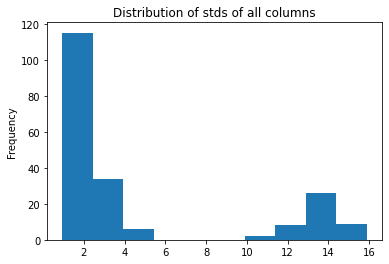

In [23]:
#данные не нормализованы, значения не от 0 до 1

display(features.std()) # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.std.html

features.std().plot(kind = 'hist', title ='Distribution of stds of all columns')


**распределены ли данные нормально?**

<AxesSubplot:title={'center':'Distribution of means of all columns'}, ylabel='Frequency'>

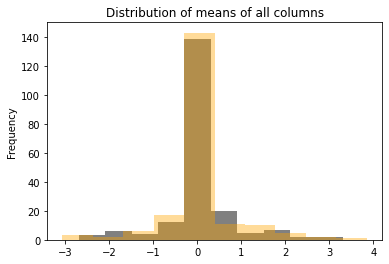

In [18]:
features.mean().plot(kind ='hist', title = 'Distribution of means of all columns',
                     color = 'gray')

features.median().plot(kind ='hist', title = 'Distribution of means of all columns',
                       color = 'orange', alpha = 0.4)

In [27]:
# проверим, что нет пустых значений
features.isnull().any().any()  # добавление нового .any() уменьшает "размерность" проверяемого

# returns True if any item in an iterable are true, otherwise it returns False

False

In [28]:
#дисбаланс классов (можно регулировать в make_classification(weights=[0.7, 0.3])

answers[0].value_counts() # число в квадратных скобках - это индекс столбца, он у нас всего один

0    698
1    302
Name: 0, dtype: int64

### обучение

In [41]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42) 
# обратите внимание на test_size

In [51]:
X_train.shape, X_test.shape, y_train.shape, y_train.shape

((750, 200), (250, 200), (750,), (750,))

In [42]:
display(np.std(X_train, axis=0)) # данные еще не нормированы, давайте это исправим

array([ 3.70097965,  0.99434625, 14.76609672,  1.03233298,  1.00374315,
        1.01813929,  1.00597249,  1.02110593, 13.30358282,  1.01327174,
        0.99986497, 15.10071029, 12.41513102,  0.97920458,  1.01133356,
        1.00374029,  3.63309721, 13.54251435,  0.99308101,  3.6725983 ,
        1.00777045,  1.01445121,  0.96811929,  1.04340382,  0.99786825,
        3.78678922,  3.77967126,  0.99415072,  0.91195279,  1.00910533,
        3.69656758,  0.98082747,  3.69097207,  1.06181972, 13.44430136,
        1.042394  ,  0.98741431, 13.7092449 ,  3.81404574, 11.32773878,
        0.95822802,  0.97765184,  0.99667081,  1.01906968, 10.67906871,
        1.04276688, 13.49728531, 13.73113649, 10.14529589,  0.94118339,
        4.0845499 ,  1.05351694,  0.99283543,  0.98913149,  0.99228164,
       13.54236821, 14.18050339, 12.02823293,  3.75381646,  0.99469337,
        1.00359616, 12.91614733,  3.7279756 , 14.67166101,  1.00140424,
        0.98488989,  3.73735738,  0.97296032,  4.00279763,  1.02

Данные нормируют, потому что дисбаланс между значениями признаков может негативно сказаться работе модели и ухудшить результаты обучения.

In [43]:
display(np.std(X_test, axis=0).min())
display(np.std(X_test, axis=0).max())

0.8772873569179627

16.41861663433815

In [44]:
#Нормируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
display(np.std(X_test, axis=0).min())
display(np.std(X_test, axis=0).max())

0.8498104562567841

1.1431109069834537

In [47]:
display(np.std(X_test, axis=0))

array([1.08185463, 1.03048666, 1.09982769, 0.84981046, 1.02406668,
       0.95300428, 0.92282145, 0.93846159, 0.90848689, 0.96148943,
       0.98574036, 1.07209825, 1.04095117, 1.05764273, 1.03211959,
       1.03105116, 1.00918526, 1.0366051 , 0.94489784, 1.03703329,
       1.00952476, 0.99128601, 0.9805913 , 1.00221956, 1.00998002,
       0.97603753, 0.97531831, 1.02562702, 1.14311091, 0.96731443,
       0.98180804, 1.08226066, 1.06653006, 0.97569593, 0.94907486,
       1.02292742, 1.11771297, 0.96661008, 1.00929623, 1.03264447,
       0.96625809, 1.02392914, 0.95736386, 0.99120113, 1.00691574,
       0.99899154, 1.01004298, 1.05236709, 1.05840164, 1.06042077,
       0.94062767, 0.97779492, 0.97565047, 0.98052585, 0.97573512,
       0.96441234, 1.03355886, 1.03056265, 0.94009772, 1.06747495,
       0.98467065, 0.96728536, 1.00719969, 1.02253468, 0.99471783,
       0.99583779, 1.00788886, 1.05606823, 1.00148753, 1.02237816,
       1.04409999, 1.02830703, 0.99963514, 1.05632906, 1.00000

In [46]:
display(np.std(X_train, axis=0).min())
display(np.std(X_train, axis=0).max())

0.9999999999999983

1.000000000000001

Теперь у нас есть матрица признаков и их значений(весов), вектор с финальными значениями, все нормировано, можно обучаться

In [57]:
# обучимся на том, что есть, и оценим качество предсказаний на трейне
model = linear_model.LogisticRegression()

model = model.fit(X_train, y_train)

train_preds = model.predict_proba(X_train)[:,1] # метод для предсказания вероятности класса

test_preds = model.predict_proba(X_test)[:,1]

In [58]:
train_preds

array([7.63338267e-01, 9.96256293e-01, 1.11141316e-02, 5.01417639e-01,
       8.13650076e-04, 2.66747849e-01, 7.97498928e-02, 8.16714339e-01,
       5.71780980e-02, 7.88960573e-01, 7.77491777e-03, 8.22681321e-01,
       1.65741945e-02, 2.07027150e-01, 9.71867954e-02, 1.97459061e-01,
       3.22206948e-04, 9.09343331e-02, 6.23257697e-01, 8.32866875e-01,
       5.04408977e-01, 1.30963419e-05, 1.27233283e-02, 9.60430818e-03,
       4.39898040e-01, 7.44342082e-01, 2.57729743e-02, 2.57498794e-01,
       8.79522086e-01, 2.02006820e-03, 2.62841533e-03, 3.76766926e-01,
       2.56738787e-01, 9.14433020e-01, 5.32674701e-02, 4.96188546e-02,
       7.94273841e-01, 7.27820147e-03, 2.21781706e-01, 2.72908715e-01,
       3.43074344e-01, 3.81899577e-01, 3.83935335e-02, 2.41906656e-03,
       8.31329904e-01, 6.06614701e-03, 2.60500219e-03, 5.12245389e-01,
       4.47469064e-01, 4.95432588e-01, 5.73464912e-02, 6.10186903e-01,
       1.65324530e-01, 3.94214597e-01, 2.01080936e-02, 9.91380332e-01,
      

In [54]:
test_preds

array([3.61578226e-01, 6.67586280e-01, 2.69414223e-02, 8.37275514e-01,
       2.11722682e-01, 6.97537269e-02, 1.25436467e-01, 6.23346573e-01,
       8.27304568e-01, 9.58308730e-01, 4.13093571e-04, 4.64552904e-02,
       7.43540986e-03, 5.23434537e-01, 8.13749780e-01, 1.12024943e-02,
       1.68371185e-03, 2.56928691e-02, 3.00093925e-01, 2.33017497e-01,
       9.82812959e-01, 9.37173950e-01, 1.84369665e-01, 1.46750161e-02,
       8.46667631e-02, 9.80747659e-01, 8.30679164e-02, 3.40957052e-03,
       1.11175716e-01, 1.11605299e-02, 8.14084060e-01, 3.88327969e-01,
       3.13864094e-02, 6.26417627e-01, 8.75625995e-01, 4.62226028e-01,
       8.43601378e-01, 7.94890822e-02, 4.04826536e-02, 1.55721548e-02,
       1.17246960e-01, 1.51791927e-02, 1.88080864e-01, 9.08519560e-02,
       3.25195830e-01, 6.53323980e-02, 5.09356990e-01, 8.24823013e-01,
       4.38464483e-01, 1.55094607e-02, 9.31915763e-03, 3.28408386e-02,
       5.48854604e-02, 3.98032090e-02, 7.62320089e-01, 3.62356226e-01,
      

In [59]:
pd.DataFrame(model.predict_proba(X_train)) # 

# model.predict_proba(X_train)[:,1].shape

,0,1
0,0.236662,0.763338
1,0.003744,0.996256
2,0.988886,0.011114
3,0.498582,0.501418
4,0.999186,0.000814
...,...,...
745,0.753481,0.246519
746,0.829519,0.170481
747,0.835931,0.164069
748,0.999633,0.000367


Регрессия для классификации? Что? Да! ([как так](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F))

## как оценить примерное качество модели, если тест закрыт?

пример из kaggle

In [60]:
print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))

print('result on test: {}'.format(roc_auc_score(y_test, test_preds)))

result on train: 0.9058110367892976
result on test: 0.7560081148564295


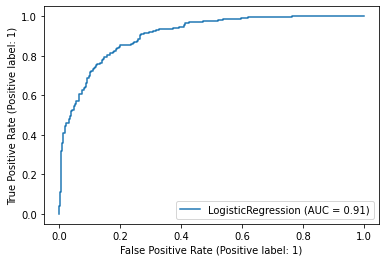

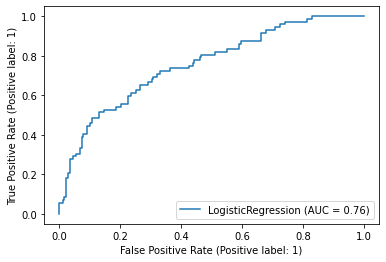

In [24]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model,X_train, y_train)

plot_roc_curve(model,X_test, y_test)

Чем выше показатель AUC, тем качественнее классификатор [что такое roc-auc](https://ru.wikipedia.org/wiki/ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F)

In [66]:
y_preds = model.predict(X_test)

In [67]:
accuracy_score(y_test, y_preds)

0.732

### Как посмотреть, какие признаки в данных -- самые важные?

В некоторых моделях, например в деревьях решений, есть встроенный метод `feature_importances_`

In [68]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
train_preds = dtc.predict_proba(X_train)[:, 1]
test_preds = dtc.predict_proba(X_test)[:, 1]

print('result on train: {}'.format(roc_auc_score(y_train, train_preds)))
print('result on test: {}'.format(roc_auc_score(y_test,test_preds)))


result on train: 1.0
result on test: 0.595661672908864


In [69]:
feature_importance = pd.DataFrame()
feature_importance["feature"] = features.columns
feature_importance["importance"] = dtc.feature_importances_
feature_importance[["feature", "importance"]].sort_values(by = 'importance', ascending = False)[:20]

,feature,importance
168,168,0.048485
58,58,0.045619
142,142,0.041850
105,105,0.036069
11,11,0.033631
108,108,0.033377
76,76,0.032819
16,16,0.028870
119,119,0.028210
48,48,0.027895
